In [693]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [694]:
import warnings
warnings.filterwarnings('ignore')

In [695]:
matplotlib.rcParams.update({'font.size': 14})

In [696]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к директориям

In [697]:
df_train = pd.read_csv(r'C:\Users\Pavlov Denis\Desktop\csv_files\project_data_from_kaggle (1)\project_data_from_kaggle\train.csv')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [698]:
df_test = pd.read_csv(r'C:\Users\Pavlov Denis\Desktop\csv_files\project_data_from_kaggle (1)\project_data_from_kaggle\test.csv')
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


# 1. Разбиение на трейн, тест, валид

In [699]:
X = df_train.drop(columns='Price')
y = df_train['Price']


In [700]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Приведение типов данных

In [701]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [702]:
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
X_train['Id'] = X_train['Id'].astype(str)
X_train['DistrictId'] = X_train['DistrictId'].astype(str)
X_valid['Id'] = X_valid['Id'].astype(str)
X_valid['DistrictId'] = X_valid['DistrictId'].astype(str)
df_test['Id'] = df_train['Id'].astype(str)
df_test['DistrictId'] = df_train['DistrictId'].astype(str)

# 2.EDA

## Целевая переменная

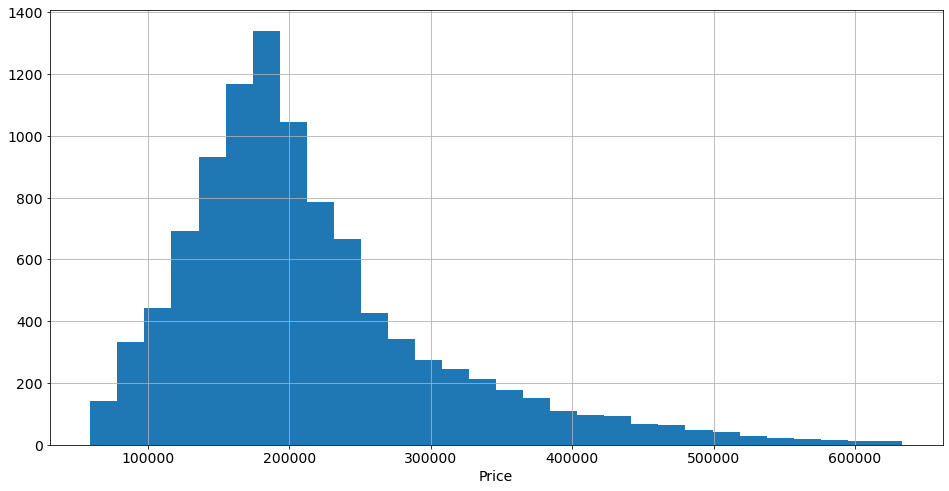

In [703]:
plt.figure(figsize = (16, 8))

df_train['Price'].hist(bins=30)
plt.xlabel('Price')
plt.show()

## Количественные переменные

In [704]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


## Номинативные переменные

In [705]:
df_train.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [706]:
class DataPreprocessing:
    """Подготовка исходных данных"""
    def __init__(self):
        self.medians = None
        self.Square_upper_quan = None
        self.Square_lower_quan = None
        self.LifeSquare_upper_quan = None
        self.LifeSquare_lower_quan = None
        self.KitchenSquare_upper_quan = None
        self.KitchenSquare_lower_quan = None
        self.SquareLifeSquare_quan = None
        self.LifeSquare_quan = None
        
    def fit(self, X):
        self.medians = X.median()
        self.Square_upper_quan = X['Square'].quantile(0.9)
        self.Square_lower_quan = X['Square'].quantile(0.025)
        self.LifeSquare_upper_quan = X['LifeSquare'].quantile(0.99)
        self.LifeSquare_lower_quan = X['LifeSquare'].quantile(0.025)
        self.KitchenSquare_upper_quan = X['KitchenSquare'].quantile(0.9)
        self.KitchenSquare_lower_quan = X['KitchenSquare'].quantile(0.025)
        self.SquareLifeSquare_quan = X['LifeSquare'].quantile(0.7)
        self.LifeSquare_quan = X['LifeSquare'].quantile(0.6)
        
    def transform(self, X):
        """Выбросы"""
        # Rooms
        X.loc[X['Rooms']== 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = 5
        # Square
        X.loc[X['Square'] > self.Square_upper_quan, 'Square'] = self.medians['Square']
        X.loc[X['Square'] < self.Square_lower_quan, 'Square'] = self.medians['Square']
        # LifeSquare
        X.loc[X['LifeSquare'] > self.LifeSquare_upper_quan, 'LifeSquare'] = self.medians['LifeSquare']
        X.loc[X['LifeSquare'] < self.LifeSquare_lower_quan, 'LifeSquare'] = self.medians['LifeSquare']
        # KitchenSquare
        X.loc[X['KitchenSquare'] > self.Square_upper_quan, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < self.Square_lower_quan, 'KitchenSquare'] = self.medians['KitchenSquare']
        # Floor, HouseFloor
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = X['HouseFloor'].median()
        X.loc[X['HouseFloor'] > 87, 'HouseFloor'] = X['HouseFloor'].median()        
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1        
        X.loc[(X['Floor'] > X['HouseFloor'], 'Floor')] = X['HouseFloor'] // 2        
        X.loc[X['Floor'] == 0, 'Floor'] = 1
        # LifeSquare, Square
        X.loc[(X['LifeSquare'] > X['Square'], 'LifeSquare')] = self.SquareLifeSquare_quan
        # HouseYear
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        """Пропуски"""
        # LifeSquare
        X.loc[X['LifeSquare'].isnull(), 'LifeSquare'] = self.LifeSquare_quan
        # HealthCare_1
        X.loc[X['Healthcare_1'].isnull(), 'Healthcare_1'] = X['Healthcare_1'].median()
        
        X.fillna(self.medians, inplace=True)
        
        return X

## 3. Обработка выбросов и пропусков

### Пропуски

<AxesSubplot:>

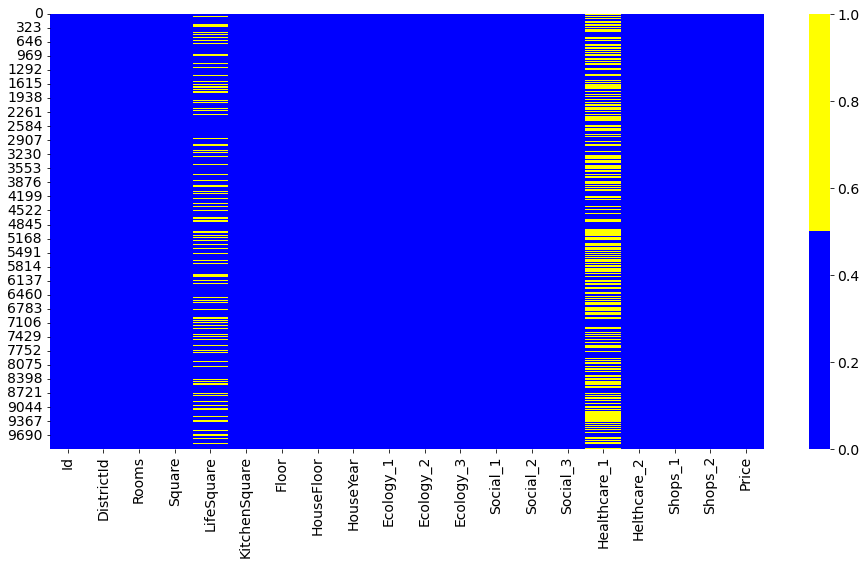

In [707]:
plt.figure(figsize = (16, 8))
cols = df_train.columns[:30]
colours = ['blue', 'yellow'] 
sns.heatmap(df_train[cols].isnull(), cmap=sns.color_palette(colours))

In [708]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

df_train = preprocessor.transform(df_train)
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
df_test = preprocessor.transform(df_test)

X_train.shape, X_valid.shape, df_test.shape

((6700, 20), (3300, 20), (5000, 20))

# 4. Построение новых признаков

In [709]:
binary_to_numbers = {'A': 0, 'B': 1}

# df_train['Ecology_2'] = df_train['Ecology_2'].replace(binary_to_numbers)
# df_train['Ecology_3'] = df_train['Ecology_3'].replace(binary_to_numbers)
# df_train['Shops_2'] = df_train['Shops_2'].replace(binary_to_numbers)
X_train['Ecology_2'] = X_train['Ecology_2'].replace(binary_to_numbers)
X_train['Ecology_3'] = X_train['Ecology_3'].replace(binary_to_numbers)
X_train['Shops_2'] = X_train['Shops_2'].replace(binary_to_numbers)

X_valid['Ecology_2'] = X_valid['Ecology_2'].replace(binary_to_numbers)
X_valid['Ecology_3'] = X_valid['Ecology_3'].replace(binary_to_numbers)
X_valid['Shops_2'] = X_valid['Shops_2'].replace(binary_to_numbers)

df_test['Ecology_2'] = df_test['Ecology_2'].replace(binary_to_numbers)
df_test['Ecology_3'] = df_test['Ecology_3'].replace(binary_to_numbers)
df_test['Shops_2'] = df_test['Shops_2'].replace(binary_to_numbers)
X_train.tail()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseFloor_outlier
9336,10466,84,3.0,76.698682,55.477526,6.0,2.0,5.0,1960,0.006076,1,1,30,5285,0,645.0,6,6,1,1
48,12307,60,1.0,40.064914,38.733288,6.0,13.0,14.0,1974,0.007659,1,1,35,7077,56,2301.0,3,19,1,0
8964,47,2,2.0,45.053898,42.276227,6.0,2.0,5.0,1967,0.000000,1,1,33,7425,1,920.0,2,5,1,0
5944,161,71,1.0,40.337987,24.811220,6.0,5.0,12.0,1984,0.407276,0,1,9,1768,0,370.0,0,0,0,0
5327,6833,47,3.0,63.543591,47.213783,6.0,5.0,12.0,1977,0.000070,1,1,46,10309,1,240.0,1,16,1,0


### District_Size

In [710]:
district_size = X_train['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'District_Size'})
district_size.head()

,DistrictId,District_Size
0,27,580
1,1,445
2,23,372
3,6,345
4,9,194


In [711]:

X_train = X_train.merge(district_size, on='DistrictId', how='left')
X_valid = X_valid.merge(district_size, on='DistrictId', how='left')
df_test = df_test.merge(district_size, on='DistrictId', how='left')

df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseFloor_outlier,District_Size
0,11809,27,1.0,36.847630,19.094182,6.0,5.0,9.0,1970,0.036122,...,1,24,4378,0,1036.0,1,1,1,0,580
1,3013,22,1.0,42.493907,42.276227,6.0,7.0,17.0,2017,0.072158,...,1,2,629,1,900.0,0,0,0,0,55
2,8215,1,2.0,59.463678,35.980058,6.0,19.0,19.0,1977,0.211401,...,1,9,1892,0,900.0,0,1,1,0,445
3,2352,1,3.0,49.646030,33.893825,6.0,2.0,2.0,1965,0.014073,...,1,2,475,0,900.0,0,0,1,0,445
4,13866,94,1.0,53.837056,35.980058,6.0,8.0,17.0,1977,0.309479,...,1,35,7715,4,990.0,0,6,1,0,58


### MedPriceByDistrictRooms and MedPriceByDistrictSquare

In [712]:
med_price_by_district_rooms = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrictRooms'})

med_price_by_district_rooms.head()

,DistrictId,Rooms,MedPriceByDistrictRooms
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202706.090239


In [713]:
X_train = X_train.merge(med_price_by_district_rooms, on=['DistrictId', 'Rooms'], how='left')
X_valid = X_valid.merge(med_price_by_district_rooms, on=['DistrictId', 'Rooms'], how='left')
df_test = df_test.merge(med_price_by_district_rooms, on=['DistrictId', 'Rooms'], how='left')


In [714]:
# Заполнение пропусков в df_test
df_test.loc[df_test['MedPriceByDistrictRooms'].isnull(), 'MedPriceByDistrictRooms'] = df_test['MedPriceByDistrictRooms'].median()

In [715]:
med_price_by_district_square = df_train.groupby(['DistrictId', 'Square'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrictSquare'})
med_price_by_district_square.head()


,DistrictId,Square,MedPriceByDistrictSquare
0,0,32.416925,125579.315184
1,0,32.967872,142799.434052
2,0,33.237857,162322.784011
3,0,34.487813,155188.251947
4,0,34.890672,176394.968051


In [716]:
X_train = X_train.merge(med_price_by_district_square, on=['DistrictId', 'Square'], how='left')
X_valid = X_valid.merge(med_price_by_district_square, on=['DistrictId', 'Square'], how='left')
df_test = df_test.merge(med_price_by_district_square, on=['DistrictId', 'Square'], how='left')
X_train.shape, X_valid.shape, df_test.shape

((6700, 23), (3300, 23), (5000, 23))

In [717]:
df_test.loc[df_test['MedPriceByDistrictSquare'].isnull(), 'MedPriceByDistrictSquare'] = df_test['MedPriceByDistrictSquare'].median()
# df_train.head()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        5000 non-null   object 
 1   DistrictId                5000 non-null   object 
 2   Rooms                     5000 non-null   float64
 3   Square                    5000 non-null   float64
 4   LifeSquare                5000 non-null   float64
 5   KitchenSquare             5000 non-null   float64
 6   Floor                     5000 non-null   float64
 7   HouseFloor                5000 non-null   float64
 8   HouseYear                 5000 non-null   int64  
 9   Ecology_1                 5000 non-null   float64
 10  Ecology_2                 5000 non-null   int64  
 11  Ecology_3                 5000 non-null   int64  
 12  Social_1                  5000 non-null   int64  
 13  Social_2                  5000 non-null   int64  
 14  Social_3

### MedPriceByFloorYear

In [718]:
def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X

def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[(X['Floor'] <= 2) | (X['Floor'] == X['HouseFloor']), 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 2) | (X['Floor'] < X['HouseFloor']), 'floor_cat'] = 2
    
    return X

In [719]:
df_train = year_to_cat(df_train)
df_train = floor_to_cat(df_train)
X_train = year_to_cat(X_train)
X_train = floor_to_cat(X_train)
X_valid = year_to_cat(X_valid)
X_valid = floor_to_cat(X_valid)
df_test = year_to_cat(df_test)
df_test = floor_to_cat(df_test)
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseFloor_outlier,District_Size,MedPriceByDistrictRooms,MedPriceByDistrictSquare,year_cat,floor_cat
0,11585,23,1.0,43.380798,35.980058,6.0,18.0,25.0,1977,0.075779,...,920.0,0,2,1,0,372,102069.270740,137057.739782,3,2
1,2917,30,3.0,52.621164,35.980058,6.0,3.0,16.0,1977,0.000078,...,1046.0,3,23,1,0,148,197817.285170,200800.673767,3,2
2,9635,47,2.0,53.610583,31.289235,6.0,6.0,12.0,1979,0.298205,...,920.0,1,3,1,1,64,222227.584211,132782.675410,3,2
3,8748,3,2.0,51.877576,30.075022,6.0,3.0,9.0,1974,0.265089,...,1937.0,3,2,1,0,44,189309.321128,170229.268401,3,2
4,5704,62,1.0,53.810968,35.980058,6.0,4.0,13.0,1977,0.072158,...,920.0,0,0,0,0,164,129107.218932,125797.832599,3,2


In [720]:
med_price_by_floor_year = df_train.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,2,343812.494282
1,2,2,509182.957515
2,3,1,181275.488970
3,3,2,184890.907615
4,4,1,272671.890168


In [721]:
df_train = df_train.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
X_train = X_train.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
X_valid = X_valid.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
df_test = df_test.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
X_train.shape, X_valid.shape, df_test.shape

((6700, 26), (3300, 26), (5000, 26))

# 5.Отбор признаков

In [722]:
X_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'HouseFloor_outlier',
 'District_Size',
 'MedPriceByDistrictRooms',
 'MedPriceByDistrictSquare',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [723]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 
                 'Shops_1', 'Shops_2']
new_feature_names = [
 'District_Size',
 'MedPriceByDistrictRooms',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']
                      


# 6. Разбиение данных

In [724]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
df_test = df_test[feature_names + new_feature_names]


In [725]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

# 7. Построение модели

### обучение

In [726]:
# from catboost import CatBoostRegressor

In [727]:
catboost_model = CatBoostRegressor(silent=True,
    learning_rate=0.1,
    iterations=1150,
    eval_metric='R2',
    depth=8)
catboost_model.fit(X_train, y_train)

Train R2:	0.976
Test R2:	0.737


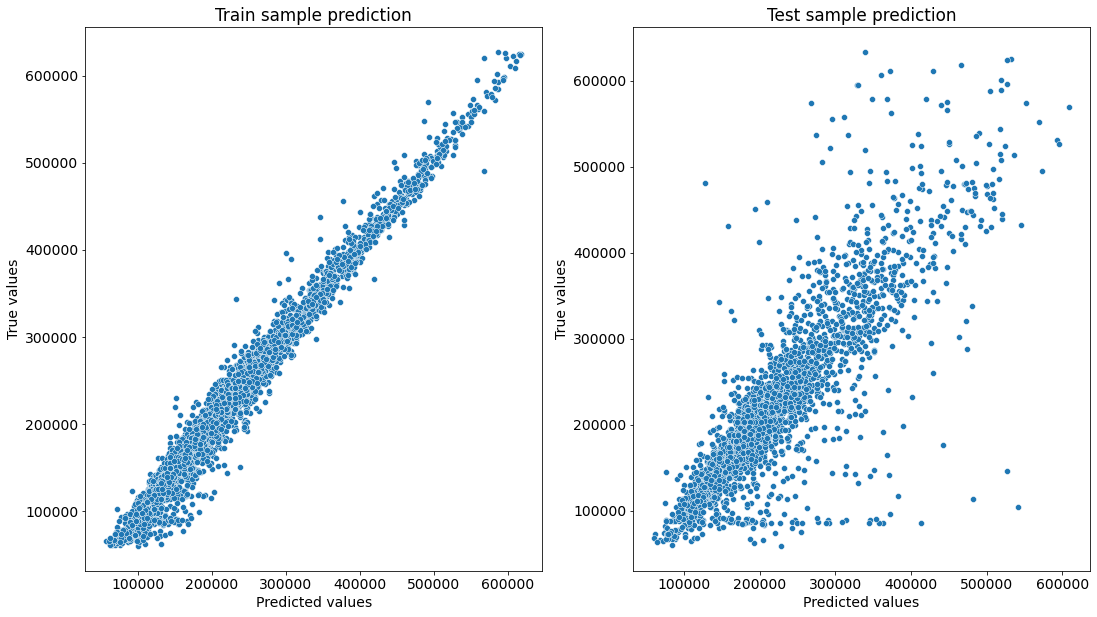

In [728]:
y_train_pred = catboost_model.predict(X_train)
y_valid_pred = catboost_model.predict(X_valid)

evaluate_preds(y_train, y_train_pred, y_valid, y_valid_pred)

### Кросс валидация

In [729]:
cv_score = cross_val_score(catboost_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.75202457, 0.72615912, 0.73469669])

In [730]:
cv_score.mean()

0.7376267930325696

### важность признаков

In [731]:
feature_importances = pd.DataFrame(zip(X_train.columns, catboost_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,MedPriceByDistrictRooms,27.749034
1,Square,12.556586
2,LifeSquare,7.066700
6,HouseYear,6.343111
5,HouseFloor,6.070070
17,District_Size,5.011488
21,MedPriceByFloorYear,4.706428
4,Floor,4.647473
11,Social_2,4.099995
7,Ecology_1,3.921275


## Прогнозирование на тестовом датасете

In [732]:
df_test.shape

(5000, 22)

In [733]:
submit = pd.read_csv(r'C:\Users\Pavlov Denis\Desktop\csv_files\project_data_from_kaggle (1)\project_data_from_kaggle\sample_submission.csv')

In [734]:
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [735]:
predictions = catboost_model.predict(df_test)
predictions

array([139453.18195291, 130850.5456576 , 165548.63799137, ...,
       132504.54755327, 207764.98066913, 274499.78703169])

In [736]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,139453.181953
1,5925,130850.545658
2,960,165548.637991
3,3848,189494.188024
4,746,181862.516472


In [603]:
submit.to_csv('C:\\Users\\Pavlov Denis\\Desktop\\csv_files\\cb_submit1.csv', index=False)